In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
import random
import matplotlib.pyplot as plt
import keras
from keras.layers import LSTM, Dropout, Dense, Flatten, Input, LeakyReLU, BatchNormalization, Conv1D, MaxPooling1D
from keras.layers import TimeDistributed, RepeatVector
from keras.models import Sequential, Model, load_model
from keras.utils import plot_model
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import graphviz
import pydot
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("C:\\Users\\Kevin\\Desktop\\Data3001\datascience-cis-2022.csv")
df['time'] = pd.to_datetime(df['time'], unit='ns')

In [3]:
df_dev1 = df[df["device_mac"] == "bd:0d:8e:c5"]
df_dev1.set_index('time', inplace=True)

In [4]:
df_1d = df_dev1['2022-09-02 00:24:59.417':'2022-09-03 00:25:00.417']
df_1d2 = df_dev1['2022-09-09 00:24:59.417':'2022-09-10 00:25:00.620']

In [5]:
dev1 = df_1d[['FromInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount',              
              'FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
              'FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
              'FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount',
              'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount',
              'ToInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount',
              'ToInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
              'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
              'ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount',
              'ToLocalUDPPort5353IP224.0.0.251/32ByteCount',
              'ToLocalUDPPort67IP255.255.255.255/32ByteCount']]

In [6]:
dev1_norm = (dev1-dev1.min())/(dev1.max()-dev1.min())
dev1_norm = dev1_norm.fillna(0)

In [7]:
dev1_clean = dev1_norm.loc[:, (dev1_norm != 0).any(axis=0)]

In [8]:
train_size = int(0.8 * len(dev1_clean))
test_size = len(dev1_clean) - train_size
train, test = dev1_clean.iloc[0:train_size], dev1_clean.iloc[train_size:len(dev1_clean)]

In [9]:
def batch(X, y, time_steps=1):
    series_X, series_Y = [], []
    for i in range(len(X) - time_steps):
        new = X.iloc[i: (i + time_steps)].to_numpy()
        series_X.append(new)
        series_Y.append(y.iloc[i + time_steps])
    return np.array(series_X), np.array(series_Y)

In [10]:
def split(X, look_back=1, forecast=1):
    series_X, series_y = [], []
    for i in range(len(X)):
        if (i + look_back + forecast) > len(X):
            break
        new = X.iloc[i: (i + look_back)]
        new_2 = X.iloc[(i + look_back): (i + look_back + forecast)]
        series_X.append(new)
        series_y.append(new_2)
    return np.array(series_X), np.array(series_y)

In [11]:
train_new, test_new = train.reset_index(drop=True), test.reset_index(drop=True)

In [12]:
X_train, y_train = split(train_new, look_back = 20, forecast = 10)
X_test, y_test = split(test_new, look_back = 20, forecast = 10)

In [13]:
TIME = 20

X_train_2, y_train_2 = batch(train, train['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)
X_test_2, y_test_2 = batch(test, test['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)

In [14]:
from datetime import datetime as dt
output_length = len(dev1_clean.columns)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(RepeatVector(10))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(50, activation='sigmoid')))
model.add(TimeDistributed(Dense(output_length)))
model.compile(optimizer='adam', loss='mse')

In [18]:
start = dt.now()
history = model.fit(X_train, y_train,
                   epochs = 30,
                   batch_size=10,
                   validation_split=0.1,
                   shuffle=False)
running_secs = (dt.now() - start).seconds
print('CNN-LSTM autoencoder runtime:', running_secs, 'seconds')

Epoch 1/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0133 - val_loss: 0.0155
Epoch 2/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0130 - val_loss: 0.0152
Epoch 3/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0128 - val_loss: 0.0158
Epoch 4/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0126 - val_loss: 0.0157
Epoch 5/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0134 - val_loss: 0.0156
Epoch 6/30
96/96 [==============================] - 1s 7ms/step - loss: 0.0140 - val_loss: 0.0153
Epoch 7/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0128 - val_loss: 0.0160
Epoch 8/30
96/96 [==============================] - 1s 7ms/step - loss: 0.0136 - val_loss: 0.0166
Epoch 9/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0132 - val_loss: 0.0152
Epoch 10/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0129 - val_loss: 0.0154
Epoch 11/30
96/96 [

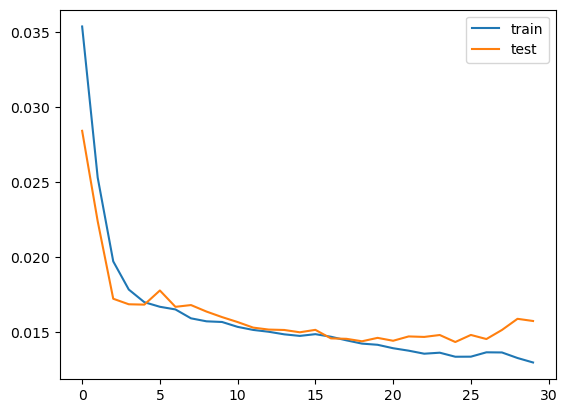

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [17]:
y_pred = model.predict(X_test)

8/8 [==============================] - 0s 4ms/step


In [18]:
y_pred_new = y_pred.transpose(2,0,1).reshape(output_length,-1).T
y_test_new = y_test.transpose(2,0,1).reshape(output_length,-1).T

In [19]:
df_pred = pd.DataFrame(y_pred_new)
df_pred.columns = ['FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount', 
                  'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount',
                  'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
                  'ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount',
                  'ToLocalUDPPort67IP255.255.255.255/32ByteCount']

In [20]:
df_test = pd.DataFrame(y_test_new)
df_test.columns = ['FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount', 
                  'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount',
                  'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
                  'ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount',
                  'ToLocalUDPPort67IP255.255.255.255/32ByteCount']

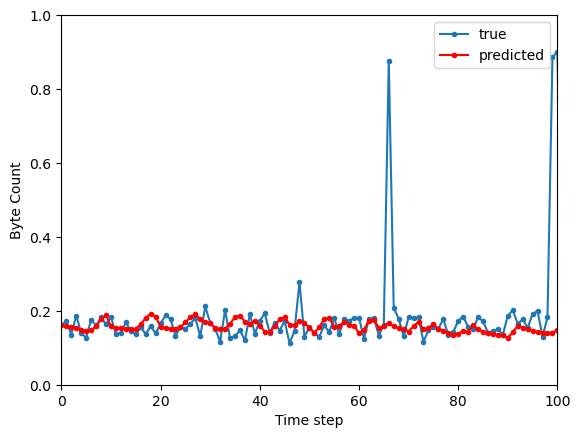

In [21]:
plt.xlim(0,100)
plt.ylim(0,1.0)
plt.plot(y_test_2, marker='.', label='true')
plt.plot(df_pred['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], 'r', marker='.', label='predicted')
plt.ylabel('Byte Count')
plt.xlabel('Time step')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [22]:
df_pred_anom = df_pred.head(254)

In [24]:
# anomaly detection
df_pred_anom['noise_to80'] = y_test_2 - df_pred_anom['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount']

In [25]:
from scipy.stats import expon as dist
upper_noise = df_pred_anom[df_pred_anom['noise_to80'] > 0]['noise_to80']
upper_params = dist.fit(upper_noise)
upper_pdf_x = upper_noise.sort_values(ascending=True).copy().values
upper_pdf_y = dist.pdf(upper_pdf_x, *upper_params)

lower_noise = (df_pred_anom[df_pred_anom['noise_to80'] < 0]['noise_to80']).abs()
lower_params = dist.fit(lower_noise)
lower_pdf_x = lower_noise.sort_values(ascending=True).copy().values
lower_pdf_y = dist.pdf(lower_pdf_x, *lower_params)

In [26]:
upper_bound_value = dist.ppf(93/100, *upper_params)
lower_bound_value = dist.ppf(93/100, *lower_params)
upper_bound_value, lower_bound_value

(0.22769587434913444, 0.05736470116066922)

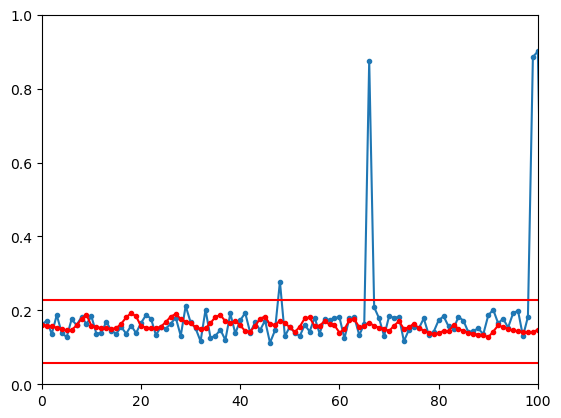

In [27]:
plt.xlim(0,100)
plt.ylim(0,1.0)
plt.plot(y_test_2, marker='.', label='true')
plt.plot(df_pred['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], 'r', marker='.', label='predicted')
plt.axhline(y=upper_bound_value, color='r')
plt.axhline(y=lower_bound_value, color='r')

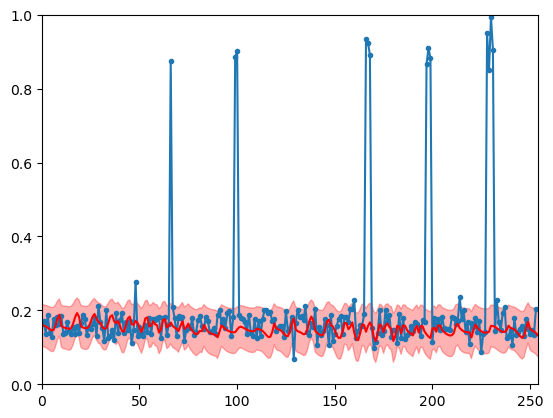

In [28]:
plt.xlim(0,254)
plt.ylim(0,1.0)
plt.plot(y_test_2, marker='.', label='true')
plt.plot(df_pred['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], 'r')
plt.fill_between(range(len(df_pred['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'])), 
                 df_pred['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'] - lower_bound_value,
                 (df_pred['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'] + upper_bound_value)/1.8,
                 color='r', alpha=.3)

In [29]:
df_pred_anom['error_to80'] = y_test_2 - df_pred_anom['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount']
result_upper = (df_pred['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'] + upper_bound_value)/1.8
result_lower = df_pred['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'] - lower_bound_value
df_pred_anom['uncertainty_to80'] = result_upper - result_lower

In [38]:
df_pred_anom['anomaly'] = 0
anomalies_to80 = df_pred_anom[df_pred_anom['error_to80'].abs() > 0.8*df_pred_anom['uncertainty_to80']]
df_pred_anom.loc[anomalies_to80.index,'anomaly'] = 1

In [39]:
df_actual = pd.DataFrame(y_test_2)
df_actual.columns = ['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount']

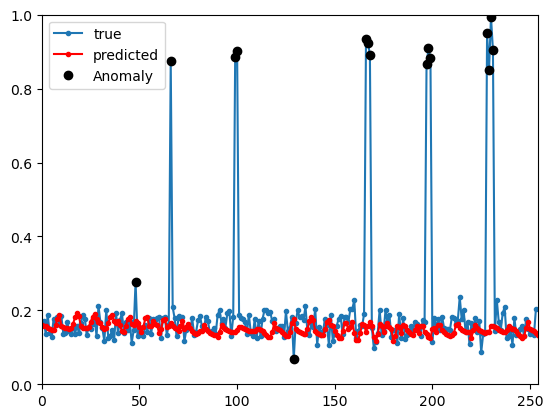

In [43]:
a = df_actual.loc[df_pred_anom['anomaly'] == 1, ['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount']]
plt.xlim(0,254)
plt.ylim(0,1.0)
plt.plot(y_test_2, marker='.', label='true')
plt.plot(df_pred['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], 'r', marker='.', label='predicted')
plt.plot(a.index, a['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'],'ro', color='black', label='Anomaly')
plt.legend()

In [46]:
X_train_3, y_train_3 = batch(train, train['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)
X_test_3, y_test_3 = batch(test, test['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)

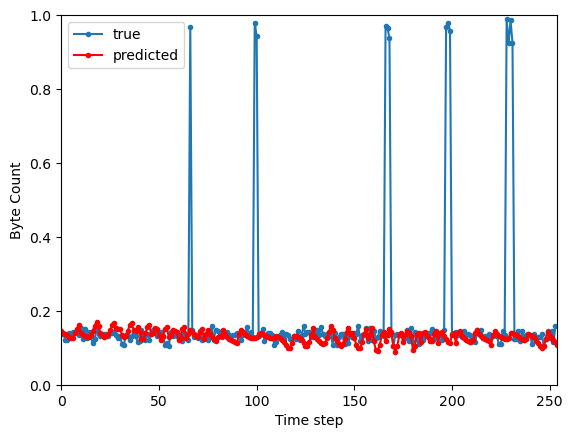

In [51]:
plt.xlim(0,254)
plt.ylim(0,1.0)
plt.plot(y_test_3, marker='.', label='true')
plt.plot(df_pred['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'], 'r', marker='.', label='predicted')
plt.ylabel('Byte Count')
plt.xlabel('Time step')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [52]:
df_pred_anom['noise_to1024'] = y_test_3 - df_pred_anom['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount']

In [53]:
upper_noise_2 = df_pred_anom[df_pred_anom['noise_to1024'] > 0]['noise_to1024']
upper_params_2 = dist.fit(upper_noise_2)
upper_pdf_x_2 = upper_noise_2.sort_values(ascending=True).copy().values
upper_pdf_y_2 = dist.pdf(upper_pdf_x_2, *upper_params_2)

lower_noise_2 = (df_pred_anom[df_pred_anom['noise_to1024'] < 0]['noise_to1024']).abs()
lower_params_2 = dist.fit(lower_noise_2)
lower_pdf_x_2 = lower_noise_2.sort_values(ascending=True).copy().values
lower_pdf_y_2 = dist.pdf(lower_pdf_x_2, *lower_params_2)

In [54]:
upper_bound_value_2 = dist.ppf(93/100, *upper_params_2)
lower_bound_value_2 = dist.ppf(93/100, *lower_params_2)
upper_bound_value_2, lower_bound_value_2

(0.2445276933392391, 0.038432836935236324)

In [55]:
df_pred_anom['error_to1024'] = y_test_3 - df_pred_anom['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount']
result_upper_2 = (df_pred['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'] + upper_bound_value_2)/1.8
result_lower_2 = df_pred['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'] - lower_bound_value_2
df_pred_anom['uncertainty_to1024'] = result_upper_2 - result_lower_2

In [69]:
df_pred_anom['anomaly_to1024'] = 0
anomalies_to1024 = df_pred_anom[df_pred_anom['error_to1024'].abs() > 0.8*df_pred_anom['uncertainty_to1024']]

In [76]:
df_pred_anom.loc[anomalies_to1024.index,'anomaly_to1024'] = 1

In [81]:
df_actual['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'] = y_test_3

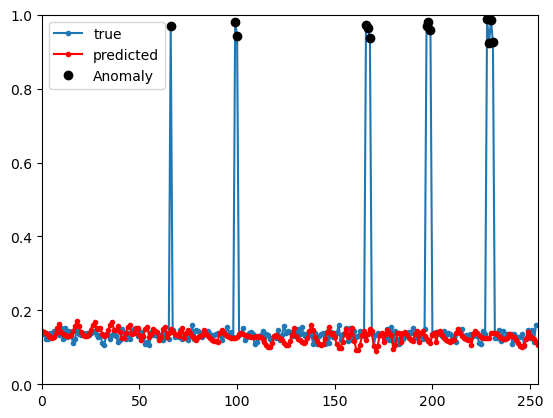

In [84]:
b = df_actual.loc[df_pred_anom['anomaly_to1024'] == 1,['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount']]
plt.xlim(0,254)
plt.ylim(0,1.0)
plt.plot(y_test_3, marker='.', label='true')
plt.plot(df_pred['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'], 'r', marker='.', label='predicted')
plt.plot(b.index, b['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'], 'ro', color='black', label='Anomaly')
plt.legend()

In [ ]:
ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount

In [85]:
X_train_4, y_train_4 = batch(train, train['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)
X_test_4, y_test_4 = batch(test, test['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)

In [107]:
df_pred_anom['noise_torsvp'] = y_test_4 - df_pred_anom['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount']

In [108]:
upper_noise_3 = df_pred_anom[df_pred_anom['noise_torsvp'] > 0]['noise_torsvp']
upper_params_3 = dist.fit(upper_noise_3)
upper_pdf_x_3 = upper_noise_3.sort_values(ascending=True).copy().values
upper_pdf_y_3 = dist.pdf(upper_pdf_x_3, *upper_params_3)

lower_noise_3 = (df_pred_anom[df_pred_anom['noise_torsvp'] < 0]['noise_torsvp']).abs()
lower_params_3 = dist.fit(lower_noise_3)
lower_pdf_x_3 = lower_noise_3.sort_values(ascending=True).copy().values
lower_pdf_y_3 = dist.pdf(lower_pdf_x_3, *lower_params_3)

In [119]:
upper_bound_value_3 = dist.ppf(93/100, *upper_params_3)
lower_bound_value_3 = dist.ppf(93/100, *lower_params_3)
upper_bound_value_3, lower_bound_value_3

(0.16192419954785878, 0.04656662708150864)

In [159]:
df_pred_anom['error_torsvp'] = y_test_4 - df_pred_anom['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount']
result_upper_3 = (df_pred['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'] + upper_bound_value_3)/1.2
result_lower_3 = df_pred['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'] - lower_bound_value_3
df_pred_anom['uncertainty_torsvp'] = result_upper_3 - result_lower_3

In [160]:
df_pred_anom['anomaly_torsvp'] = 0
anomalies_torsvp = df_pred_anom[df_pred_anom['error_torsvp'].abs() > df_pred_anom['uncertainty_torsvp']]

In [161]:
df_pred_anom.loc[anomalies_torsvp.index, 'anomaly_torsvp'] = 1

In [162]:
df_actual['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'] = y_test_4

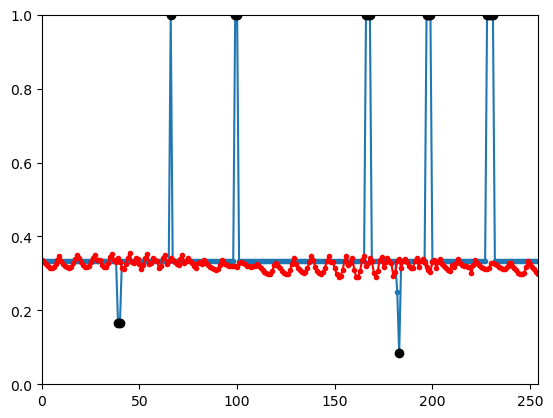

In [163]:
c = df_actual.loc[df_pred_anom['anomaly_torsvp'] == 1, ['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount']]
plt.xlim(0,254)
plt.ylim(0,1.0)
plt.plot(y_test_4, marker='.', label='true')
plt.plot(df_pred['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'], 'r', marker='.', label='predicted')
plt.plot(c.index, c['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'], 'ro', color='black', label='Anomaly')

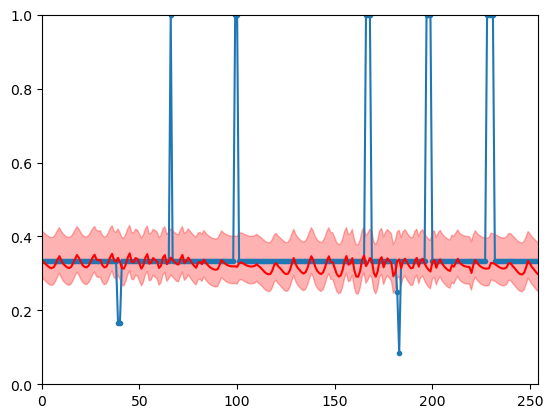

In [164]:
plt.xlim(0,254)
plt.ylim(0,1.0)
plt.plot(y_test_4, marker='.', label='true')
plt.plot(df_pred['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'], 'r')
plt.fill_between(range(len(df_pred['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'])), 
                 df_pred['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'] - lower_bound_value_3,
                 (df_pred['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'] + upper_bound_value_3)/1.2,
                 color='r', alpha=.3)

In [165]:
anomalies_to80.index

Int64Index([48, 66, 99, 100, 129, 166, 167, 168, 197, 198, 199, 228, 229, 230,
            231],
           dtype='int64')

In [166]:
anomalies_to1024.index

Int64Index([66, 99, 100, 166, 167, 168, 197, 198, 199, 228, 229, 230, 231], dtype='int64')

In [167]:
anomalies_torsvp.index

Int64Index([39, 40, 66, 99, 100, 166, 167, 168, 183, 197, 198, 199, 228, 229,
            230, 231],
           dtype='int64')

In [169]:
list(set.intersection(*map(set, [anomalies_torsvp.index, anomalies_to80.index, anomalies_to1024.index])))

[66, 99, 100, 197, 166, 167, 168, 198, 199, 228, 229, 230, 231]

In [170]:
list(set.difference(*map(set, [anomalies_torsvp.index, anomalies_to80.index, anomalies_to1024.index])))

[40, 183, 39]